In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml
from copy import deepcopy

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate_mlp import J

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/aerial/03_model_weights/resnet"
MODEL_NAME = "20240322_1039"

In [4]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)
config

{'mean_RGB_values_path': 'data/01_raw_images/rgb_means.npy',
 'ml_data_dir': 'data/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/03_model_weights/resnet',
 'probas_dir': 'data/04_predictions'}

In [5]:
IMG_SIZE = 572
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [6]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")


In [7]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [8]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


1500it [00:27, 54.91it/s] 


In [9]:
test_pred_probas, test_res_emb, test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

0it [00:00, ?it/s]

2300it [00:10, 212.84it/s]


In [10]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]


In [11]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

# Fit CRC

In [12]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [13]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 1230/1230 [02:58<00:00,  6.91it/s]


In [14]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.16])

In [15]:
cal_res_emb.min(), cal_res_emb.max()

(-0.7717674374580383, 0.7633820176124573)

# Fit multi-accurate with ResNet embedding

In [16]:
class Model(torch.nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 2048)
        self.fc2 = torch.nn.Linear(2048, 4096)
        self.fc3 = torch.nn.Linear(4096, 2048)
        self.fc4 = torch.nn.Linear(2048, 1024)
        self.fc5 = torch.nn.Linear(1024, 512)
        self.fc6 = torch.nn.Linear(512, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight) 
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc3.bias)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        torch.nn.init.zeros_(self.fc4.bias)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        torch.nn.init.zeros_(self.fc5.bias)
        torch.nn.init.xavier_uniform_(self.fc6.weight)
        torch.nn.init.zeros_(self.fc6.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = self.fc6(x)
        return x[:, 0]

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, mask, mask_pred, pred_th, alpha):
        # Loss with ridge regularization
        
        return J(mask, mask_pred, pred_th.detach().cpu().numpy(), alpha, len(mask))

In [17]:
class MLP:
    def __init__(self, mask, mask_pred, emb, alpha, lr, loss_weight_decay, scheduler_step_size, scheduler_gamma):
        self.mask = mask
        self.mask_pred = mask_pred
        self.emb = emb
        self.alpha = alpha
        self.weight_decay = loss_weight_decay
        self.lr = lr
        self.gamma = scheduler_gamma
        self.step_size = scheduler_step_size

    def fit(self, X, y=None):
        emb = torch.tensor(self.emb[X], dtype=torch.float32)
        mask = self.mask[X]
        mask_pred = self.mask_pred[X]
        loss = 0
        count_bad_conv = -1
        while int(loss) == 0:
            count_bad_conv += 1
            print(f"count_bad_conv = {count_bad_conv}")

            self.model, loss = self._train_mlp(emb, mask, mask_pred, patience=10)
        return self

    def _train_mlp(self, emb, mask, mask_pred, patience):
        print(emb.shape, mask.shape, mask_pred.shape)
        model = Model(emb.shape[1]).to("cuda")
        criterion = CustomLoss()
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=self.step_size, gamma=self.gamma)
        min_loss = np.inf
        best_model = None
        for epoch in range(1000):
            optimizer.zero_grad()
            th_pred = model(emb.to("cuda"))

            loss = torch.tensor(criterion(mask, mask_pred, th_pred.detach(), self.alpha))

            if loss < min_loss:
                min_loss = loss
                best_model = deepcopy(model)
                count_patience = 0
            else:
                count_patience += 1
                if count_patience > patience:
                    break
            print(
                f"Epoch {epoch}, loss {loss} - mean-th {th_pred.mean()} - min-th {th_pred.min()}"\
                     f" - max-th {th_pred.max()} - lr {scheduler.get_last_lr()}"
            )
            th_pred.backward(loss.repeat(len(emb)).to("cuda"))
            optimizer.step()
            scheduler.step()
        print(min_loss)
        return best_model, min_loss

    def predict(self, emb):
        with torch.no_grad():
            emb = torch.tensor(emb, dtype=torch.float32).to("cuda")
            print(emb.shape)
            return self.model(emb)[:, None, None].cpu().numpy()

    def score(self, X, y=None):
        mask = self.mask[X]
        mask_pred = self.mask_pred[X]
        emb = torch.tensor(self.emb[X], dtype=torch.float32)
        print(mask.shape, mask_pred.shape, emb.shape)

        th_pred = self.predict(emb)
        return J(mask, mask_pred, th_pred, self.alpha, len(mask))


In [18]:
class MLP:
    def __init__(self, mask, mask_pred, emb, alpha, lr, loss_weight_decay, scheduler_step_size, scheduler_gamma):
        self.mask = mask
        self.mask_pred = mask_pred
        self.emb = emb
        self.alpha = alpha
        self.weight_decay = loss_weight_decay
        self.lr = lr
        self.gamma = scheduler_gamma
        self.step_size = scheduler_step_size

    def fit(self, X, y=None):
        emb = torch.tensor(self.emb[X], dtype=torch.float32)
        mask = self.mask[X]
        mask_pred = self.mask_pred[X]
        loss = 0
        count_bad_conv = -1
        while int(loss) == 0:
            count_bad_conv += 1
            print(f"count_bad_conv = {count_bad_conv}")

            self.model, loss = self._train_mlp(emb, mask, mask_pred, patience=10)
        return self

    def _train_mlp(self, emb, mask, mask_pred, patience):
        print(emb.shape, mask.shape, mask_pred.shape)
        model = Model(emb.shape[1]).to("cuda")
        criterion = CustomLoss()
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=self.step_size, gamma=self.gamma)
        min_loss = np.inf
        best_model = None
        for epoch in range(1000):
            optimizer.zero_grad()
            th_pred = model(emb.to("cuda"))

            loss = torch.tensor(criterion(mask, mask_pred, th_pred.detach(), self.alpha))

            if loss < min_loss:
                min_loss = loss
                best_model = deepcopy(model)
                count_patience = 0
            else:
                count_patience += 1
                if count_patience > patience:
                    break
            print(
                f"Epoch {epoch}, loss {loss} - mean-th {th_pred.mean()} - min-th {th_pred.min()}"\
                     f" - max-th {th_pred.max()} - lr {scheduler.get_last_lr()}"
            )
            th_pred.backward(loss.repeat(len(emb)).to("cuda"))
            optimizer.step()
            scheduler.step()
        print(min_loss)
        return best_model, min_loss

    def predict(self, emb):
        with torch.no_grad():
            emb = torch.tensor(emb, dtype=torch.float32).to("cuda")
            print(emb.shape)
            return self.model(emb)[:, None, None].cpu().numpy()

    def score(self, X, y=None):
        mask = self.mask[X]
        mask_pred = self.mask_pred[X]
        emb = torch.tensor(self.emb[X], dtype=torch.float32)
        print(mask.shape, mask_pred.shape, emb.shape)

        th_pred = self.predict(emb)
        return J(mask, mask_pred, th_pred, self.alpha, len(mask))


In [19]:
mlp = MLP(
    cal_labels, cal_pred_probas, cal_res_emb, alpha=ALPHA, lr=1e-8,
    loss_weight_decay=1000, scheduler_step_size=50, scheduler_gamma=.8
)
mlp.fit(np.arange(len(cal_labels)))

count_bad_conv = 0
torch.Size([1230, 1024]) (1230, 572, 572) (1230, 572, 572)
Epoch 0, loss -9.910064867290629 - mean-th 0.0020980911795049906 - min-th -0.015947220847010612 - max-th 0.017062537372112274 - lr [1e-08]
Epoch 1, loss -9.910300667057378 - mean-th 0.005200306884944439 - min-th -0.012669727206230164 - max-th 0.02094586379826069 - lr [1e-08]
Epoch 2, loss -9.910510428339933 - mean-th 0.008299577981233597 - min-th -0.00935877300798893 - max-th 0.024767182767391205 - lr [1e-08]
Epoch 3, loss -9.910703030661473 - mean-th 0.011394395492970943 - min-th -0.006037048529833555 - max-th 0.028567388653755188 - lr [1e-08]
Epoch 4, loss -9.910884708185852 - mean-th 0.01448313519358635 - min-th -0.0027885115705430508 - max-th 0.032364990562200546 - lr [1e-08]
Epoch 5, loss -9.91105719317128 - mean-th 0.017565246671438217 - min-th 0.00045289238914847374 - max-th 0.03648027777671814 - lr [1e-08]
Epoch 6, loss -9.911220000182736 - mean-th 0.020641669631004333 - min-th 0.00370408920571208 - m

KeyboardInterrupt: 

In [ ]:
mlp.score(np.arange(len(cal_labels)))

(1221, 64, 64) (1221, 64, 64) torch.Size([1221, 1024])
torch.Size([1221, 1024])


/tmp/ipykernel_1593795/2627984888.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(emb, dtype=torch.float32).to("cuda")


-9.914331334390344

In [ ]:
ths_res = mlp.predict(test_res_emb)
ths_res.shape

torch.Size([2300, 1024])


(2300, 1, 1)

# Apply thresholds on pred-probas

In [ ]:
y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

/tmp/ipykernel_1593795/2065774704.py:2: RuntimeWarning: invalid value encountered in divide
  recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1593795/2065774704.py:5: RuntimeWarning: invalid value encountered in divide
  recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))


In [ ]:
precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
precision_test_crc =(y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


/tmp/ipykernel_1593795/3101535864.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
/tmp/ipykernel_1593795/3101535864.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_crc =(y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


# Plot results

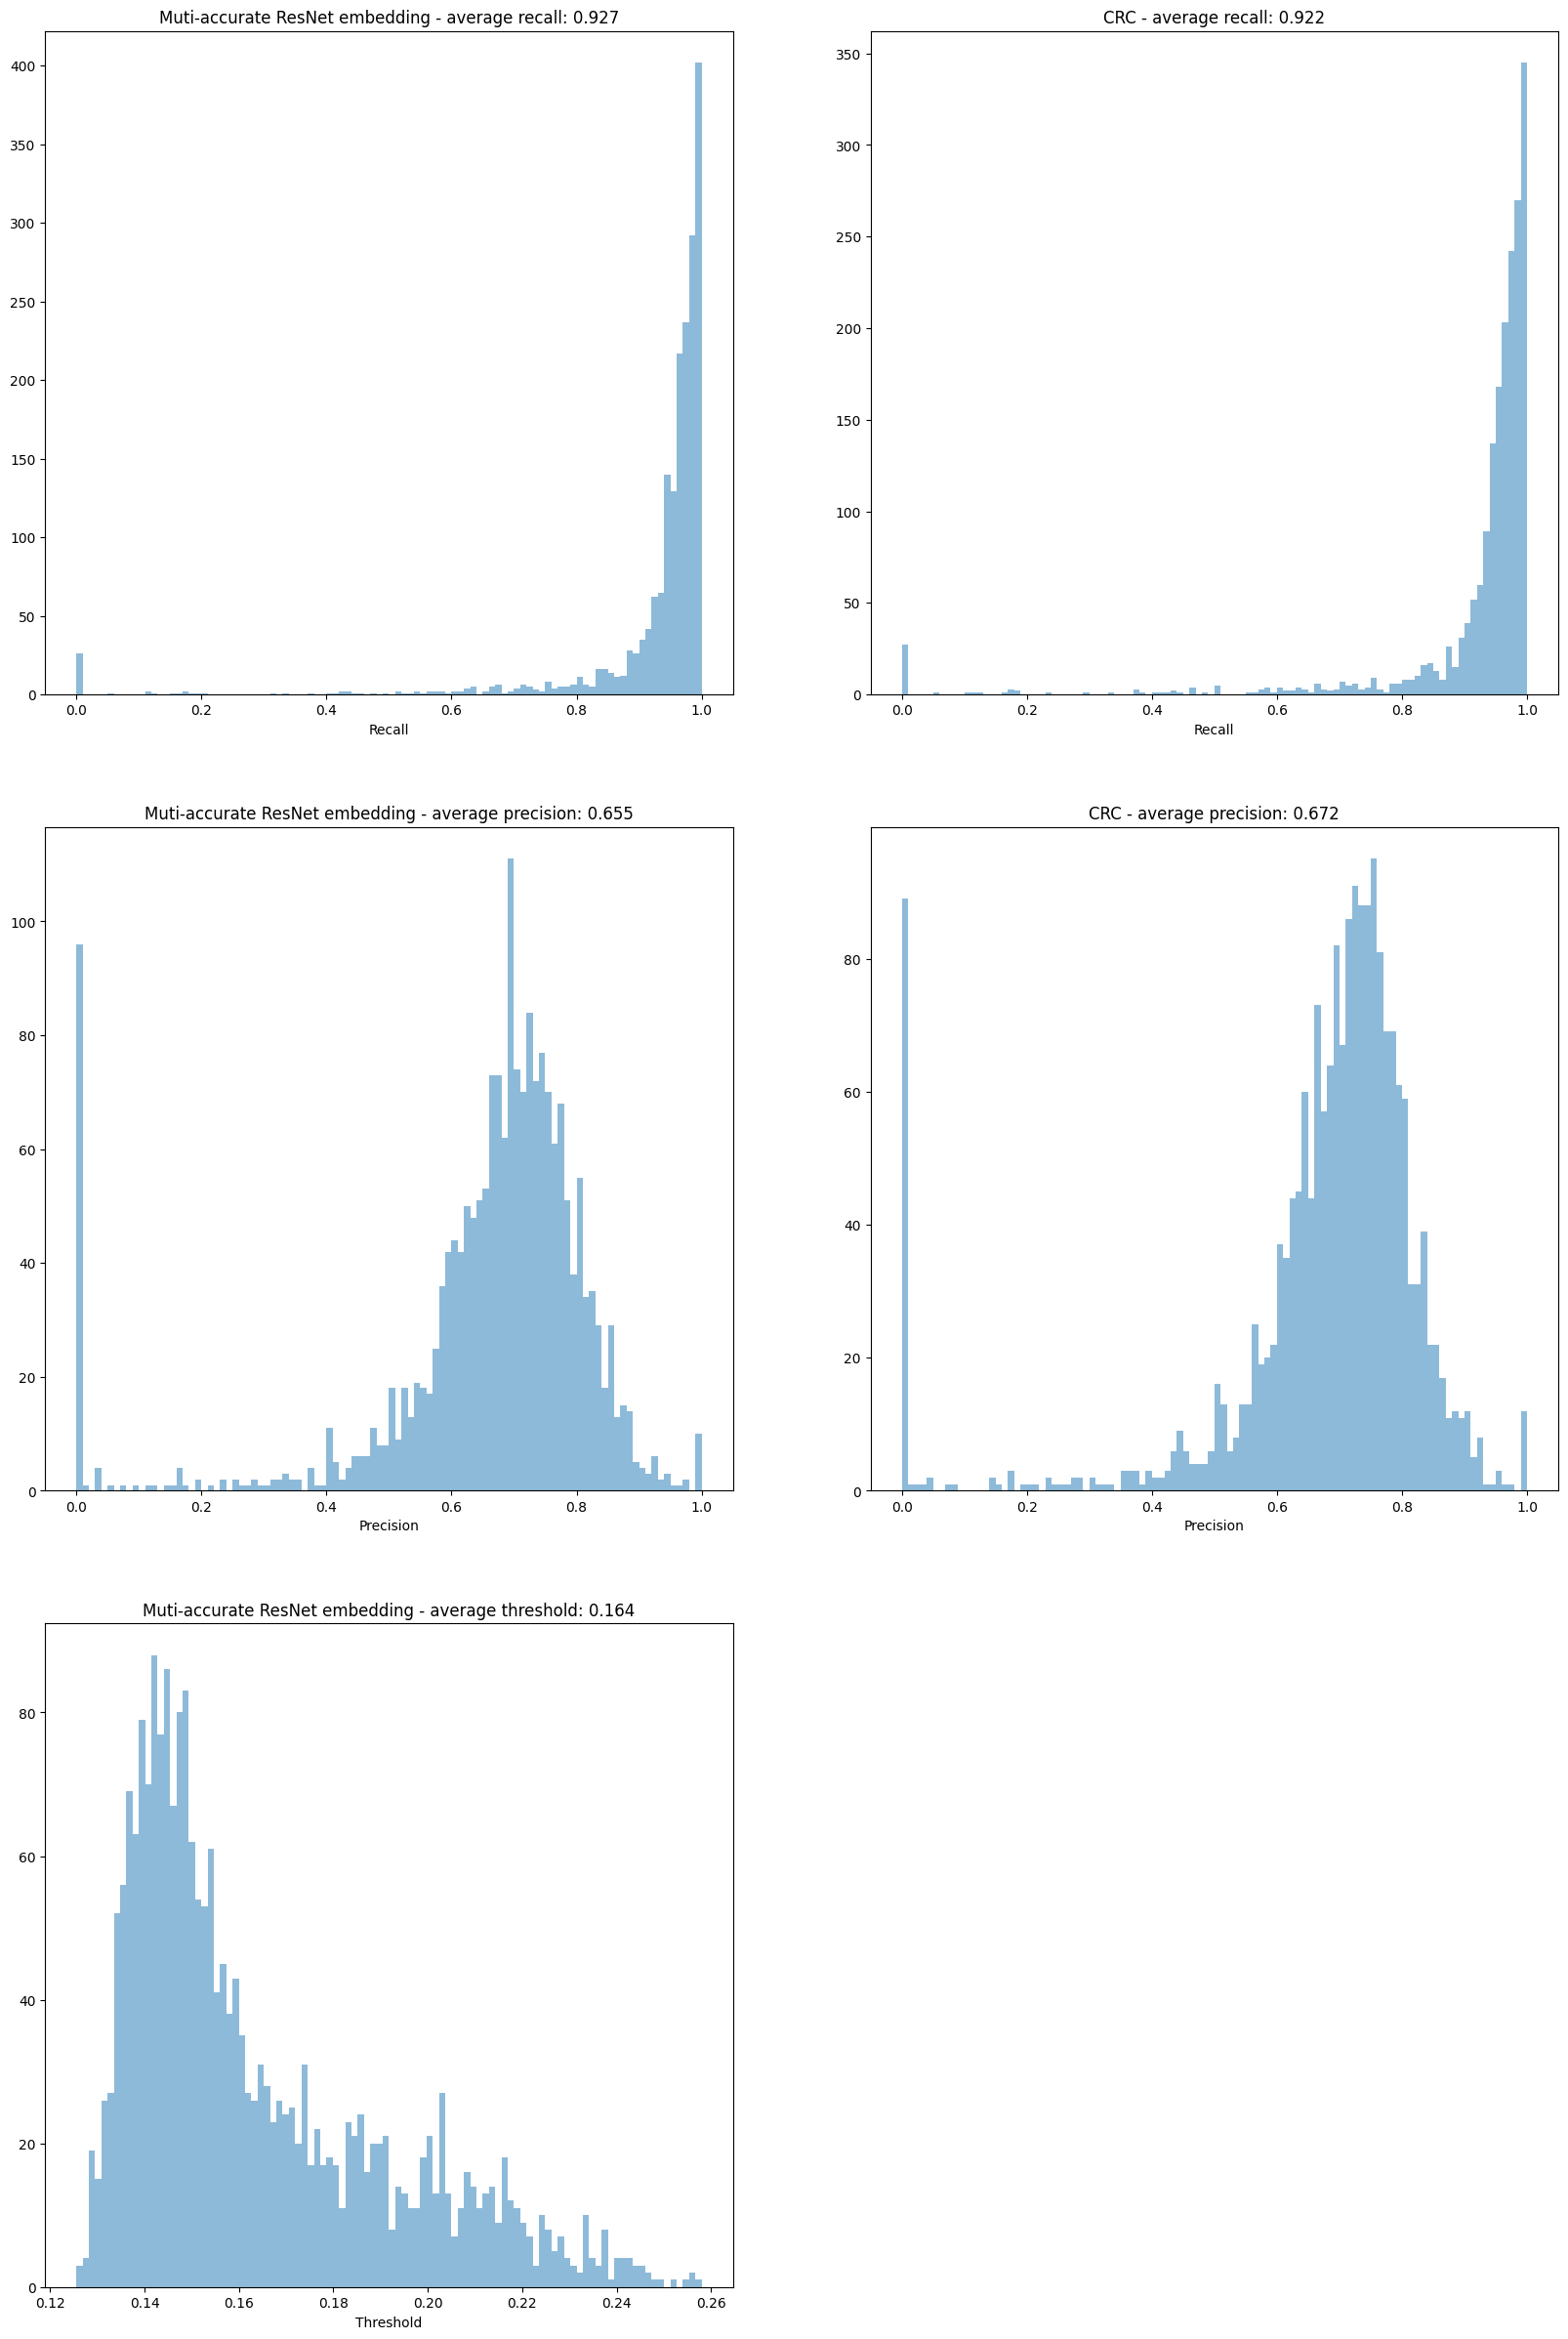

In [ ]:
s = 10
nrow = 3
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))



ax[0, 0].hist(recall_resnet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recall_resnet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precision_test_resnet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precision_test_resnet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.3f}")
ax[1, 1].set_xlabel("Precision")

ax[2, 0].hist(ths_res[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate ResNet embedding - average threshold: {np.nanmean(ths_res):.3f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].set_axis_off()

# Check shape of J

In [ ]:
test_res_emb[0][None, ...].shape

In [ ]:
model(torch.tensor(test_res_emb[0][None, ...], dtype=torch.float).to("cuda"))

In [ ]:
weights = model.state_dict()["fc1.weight"].cpu().numpy()[0, :]
bias = model.state_dict()["fc1.bias"].cpu().numpy()

pred_hand = np.dot(test_res_emb, weights) + bias
pred_hand

In [ ]:
weights = model.state_dict()["fc1.weight"].cpu().numpy()[0, :]
bias = model.state_dict()["fc1.bias"].cpu().numpy()
argsort = np.argsort(np.abs(weights))[::-1]

n_cols = 3
n_rows = 3
s = 10
f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * s, n_rows * s))

count = 0
for i in tqdm(range(n_rows)):
    for j in range(n_cols):
        weights_modified = weights.copy()
        real_pred = np.dot(cal_res_emb, weights) + bias
        J_real = J(cal_labels, cal_pred_probas, real_pred, .1, len(cal_labels)).mean() + .1 * np.linalg.norm(weights) **2
        new_ws = np.linspace(weights[argsort[count]] - 1, weights[argsort[count]] + 1, 100)
        Js = []
        for new_w in new_ws:
            weights_modified[argsort[count]] = new_w
            pred_hand = np.dot(cal_res_emb, weights_modified) + bias
            Js.append(J(cal_labels, cal_pred_probas, pred_hand, .1, len(cal_labels)).mean() + .1 * np.linalg.norm(weights_modified) **2)
        Js = np.array(Js)
        sorted_indices = np.argsort(new_ws)
        ax[i, j].plot(new_ws[sorted_indices], Js[sorted_indices])
        ax[i, j].scatter(weights[argsort[count]], J_real, c="red")
        ax[i, j].set_title(f"Weight {argsort[count]} - value {weights[argsort[count]]}")

        count += 1


In [ ]:
plt.plot(Js)

In [ ]:
plt.hist(precision_test_resnet - precision_test_crc)
plt.show()

In [ ]:
np.nanmean((precision_test_resnet - precision_test_crc))

In [ ]:
plt.hist(recall_resnet - recall_test_crc)
plt.show()

In [ ]:
np.nanmean(precision_test_unet)
t_unet = []
for i in precision_test_unet:
    if i == 0:
        continue
    else:
        t_unet.append(i)

t_resnet = []
for i in precision_test_resnet:
    if i == 0:
        continue
    else:
        t_resnet.append(i)

t_crc = []
for i in precision_test_crc:
    if i == 0:
        continue
    else:
        t_crc.append(i)

np.nanmean(t_unet), np.nanmean(t_resnet), np.nanmean(t_crc)

In [ ]:
np.nanmean(t)

In [ ]:
len(precision_test_unet)